# Perkenalan

Dibuat oleh Arry Pandowo student Fullstack Data Science Batch #01 Hacktiv8 untuk pemenuhan Live Code 3 Phase 1


***

## Problems

Data set yang digunakan adalah [berikut]('https://www.kaggle.com/amansaxena/lifeexpectancy') dimana data tersebut merupakan dataset mengenai life expectancy ranking atas negara negara di dunia yang dibagi berdasarkan jenis kelamin dan informasi mengenai letak negara pada benua mana.

Tujuan dari Live code ini adalah untuk : 
<ol>
<li>menggunakan K-means untuk mencari kelompok negara yang memiliki anomally atau outlier</li>
<li>mengidentifikasi karakteristik masing masing cluster</li>
<li>melakukan analisis terhadap data dan hubungan antar fitur sebagai insight dalam melakukan analisis</li>
</ol>

***

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans
from pandas import get_dummies

Import library lainnya dibawah

***

# Data Loading

In [3]:
df = pd.read_csv('Data/Life_expectancy_dataset.csv')

In [4]:
df.head()

,Rank,Country,Overall Life,Male Life,Female Life,Continent
0,1,Monaco,89.5,85.6,93.5,Europe
1,2,Japan,85.0,81.7,88.5,Asia
2,3,Singapore,85.0,82.3,87.8,Asia
3,4,Macau; China,84.5,81.6,87.6,Asia
4,5,San Marino,83.3,80.7,86.1,Europe


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          223 non-null    int64  
 1   Country       223 non-null    object 
 2   Overall Life  223 non-null    float64
 3   Male Life     223 non-null    float64
 4   Female Life   223 non-null    float64
 5   Continent     223 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.6+ KB


## Data Null 

In [6]:
df.isna().sum()

Rank            0
Country         0
Overall Life    0
Male Life       0
Female Life     0
Continent       0
dtype: int64

Data tidak memiliki nilai Null, dapat diolah lebih lanjut

## Skewness Score

In [7]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

In [8]:
for columns in df_numeric:
    print('Nilai Skewness ' + columns + ' adalah', df[columns].skew())

Nilai Skewness Rank adalah 0.0
Nilai Skewness Overall Life adalah -0.896327516670228
Nilai Skewness Male Life adalah -0.7894352253835046
Nilai Skewness Female Life adalah -0.9647680524178575


Data tidak memiliki kecenderungan skew ke satu sisi tertentu secara ekstrim (diatas 1 atau -1) sehinga aman untuk diolah lebih lanjut
***

# Data Cleaning

Untuk Sementara tidak diperlukan
***

# Eksplorasi Data

## Distribusi data 

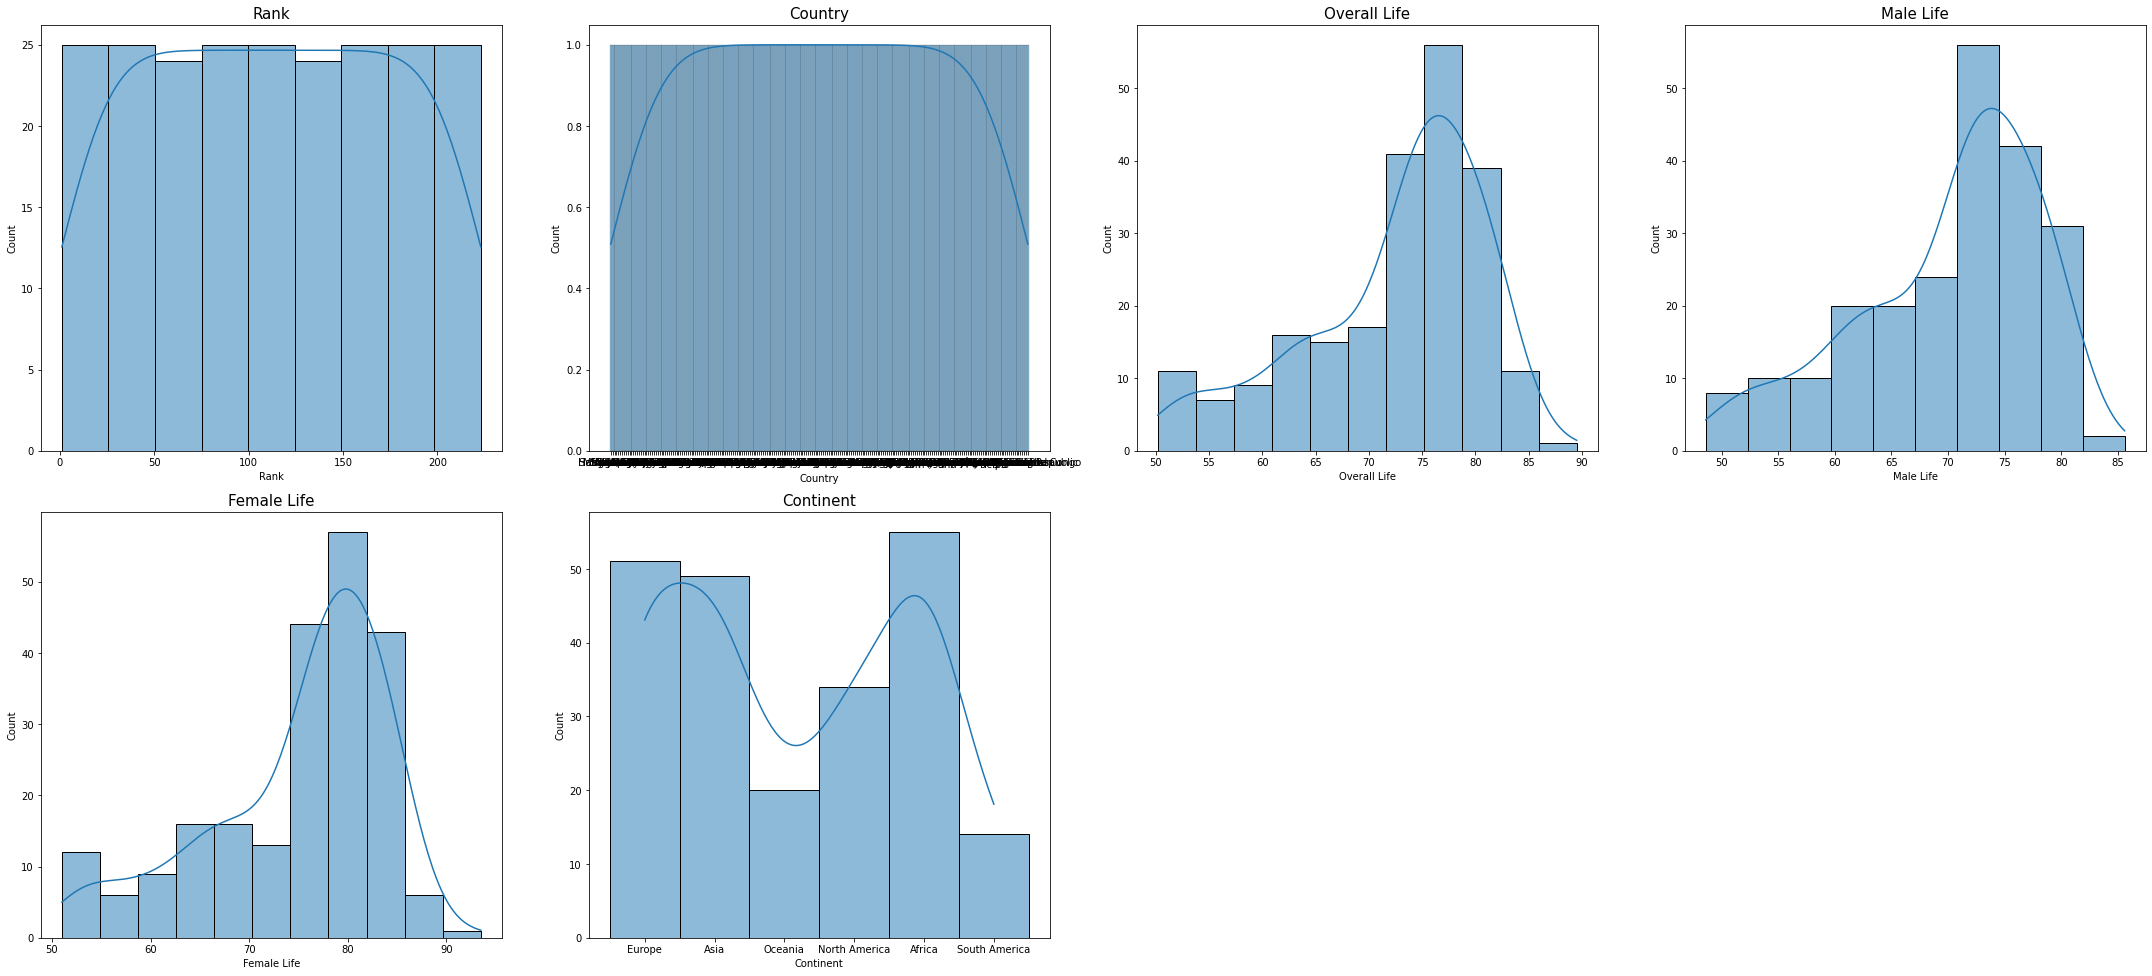

In [9]:
cols = list(df.columns)
plt.figure(figsize = (30, 20))
for i in range(len(cols)):
    plt.subplot(len(cols)//3+1, 4, i + 1)
    sns.histplot(df[cols[i]], kde=True)
    plt.title(cols[i], fontsize = 15)
    
plt.tight_layout()
plt.show()

Distribusi data aman, tidak ada kecenderungan skewness score yang tinggi sehingga aman diolah lebih lanjut


## Boxplot Dataset

<AxesSubplot:>

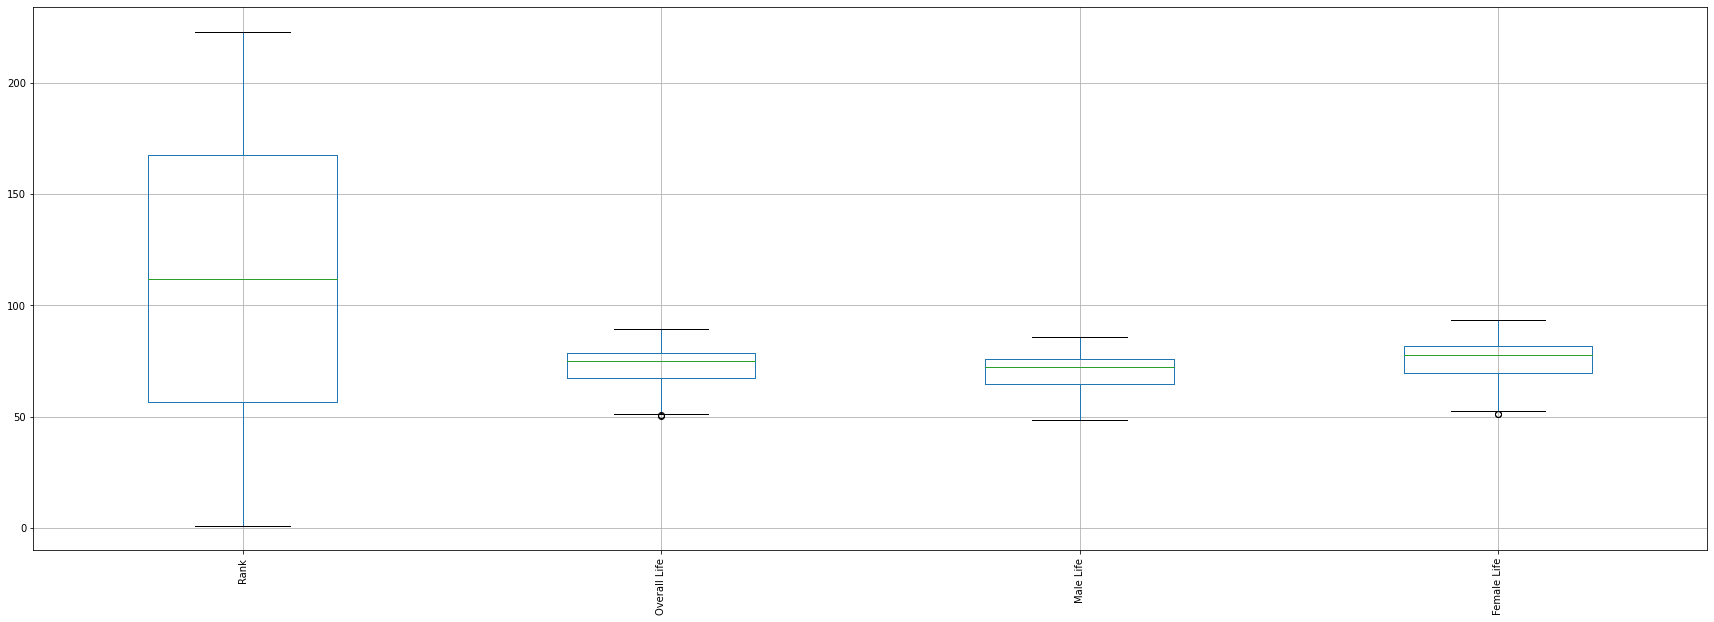

In [10]:
df.boxplot(rot=90, figsize=(30,10))

Tidak terdapat banyak outlier dari data yang akan diproses, cukup aman untuk ditindaklanjuti

## Angka Life Expectancy berdasarkan jenis kelamin & Overall

### Male

<AxesSubplot:xlabel='Continent', ylabel='Male Life'>

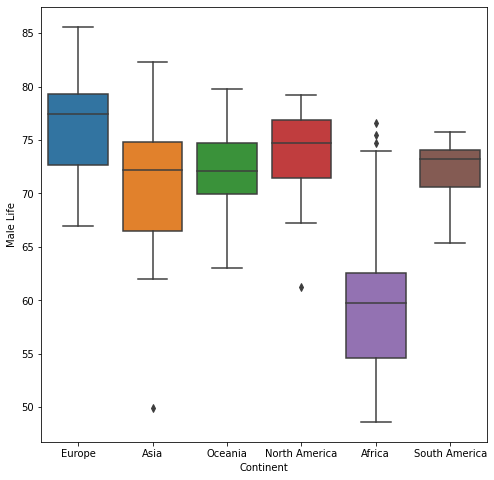

In [11]:
plt.figure(figsize=(8 ,8))
sns.boxplot(data=df,x='Continent',y="Male Life")

* Berdasarkan Benua, Life Expectancy Laki laki dibenua eropa jauh lebih tinggi dibandingkan dengan negara lainnya
* Afrika memiliki angka harapan hidup terendah untuk laki laki namun terdapat banyak data outlier untuk umur yang lebih tinggi
* Terdapat negara di Asia memiliki data outlier pada pria untuk usia yang lebih rendah 

### Female

<AxesSubplot:xlabel='Continent', ylabel='Female Life'>

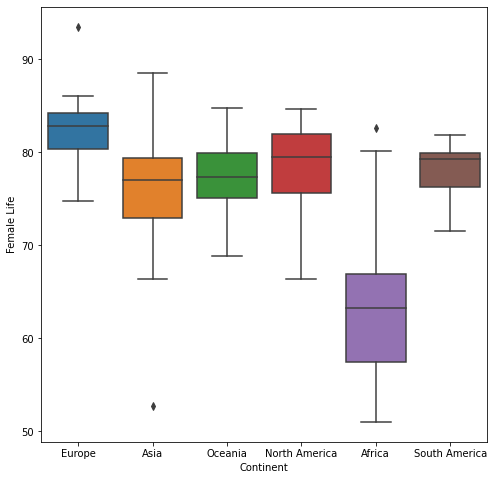

In [12]:
plt.figure(figsize=(8 ,8))
sns.boxplot(data=df,x='Continent',y="Female Life")

### Overall

<AxesSubplot:xlabel='Continent', ylabel='Overall Life'>

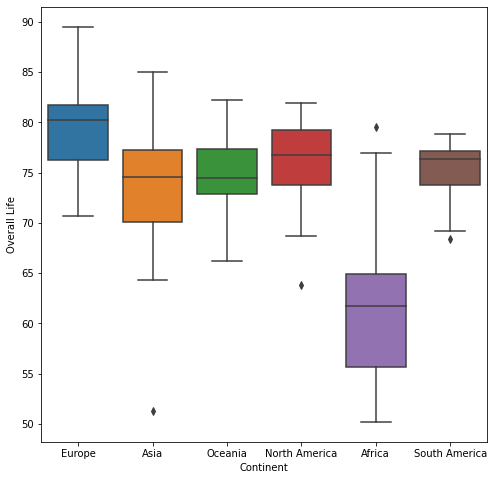

In [13]:
plt.figure(figsize=(8 ,8))
sns.boxplot(data=df,x='Continent',y="Overall Life")

* Pola distribusi data tidak jauh berbeda namun terdapat sebaran outlier yg lebih tinggi pada negara eropa untuk angka harapan hidup wanita  

# Data Preprocessing

## Get Dummies Country and Continent

In [14]:
df = pd.get_dummies(df, columns=['Country', 'Continent'], drop_first=True)

## Multicollinearity Test

In [15]:
df_PCA = df_numeric.drop(['Rank'], axis = 1)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df_PCA.columns
vif_data["VIF"] = [variance_inflation_factor(df_PCA.values, i) for i in range(len(df_PCA.columns))]
vif_data

,feature,VIF
0,Overall Life,62818.830548
1,Male Life,17786.966015
2,Female Life,16705.351365


dengan tingginya Multicollinearity antar feature, maka diperlukan dimentional reduction dengan metode PCA

## Dimentional Reduction dengan PCA

### Standar Scalling dan penentuan feature yang akan dilakukan dimentional reduction

Diputuskan yang dilakukan dimentional reduction adalah Overall Life, Male Life dan Female Life dikarenakan : 
* Memenuhi kriteria data numerik non kategorik dan ordinal
* memiliki skor VIF besar sehingga berpotensi menimnbulkan bias ketika data digunakan dalam proses training atau analisis lainnya

In [17]:
# scale the DataFrame
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_PCA_scalled=scaler.fit_transform(df_PCA)

C:\Users\arryp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


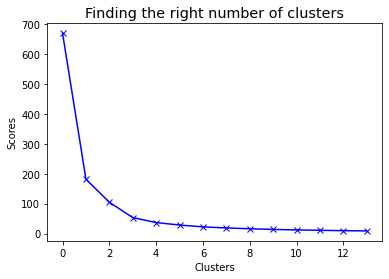

In [18]:
scores_1 = []

range_values = range(1,15)
for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_PCA_scalled)
    scores_1.append(kmeans.inertia_)
plt.plot(scores_1, 'bx-')
plt.style.use('ggplot')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

### mencari K

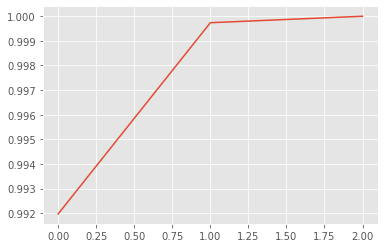

In [19]:
from sklearn.decomposition import PCA
pca=PCA(whiten=True)
pca.fit(df_PCA_scalled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(cumsum)

In [20]:
cumsum.tolist()

[0.9919683778626576, 0.9997370609668289, 1.0]

Berdasarkan kedua skor diatas maka didapat : 
* dipilihnya n_components 1 dikarenakan skor inertia berada pada patahan ekstrim yang menandakan centroid telah berhasil mengumpulkan data cluster
* hal tersebut juga didukung dengan nilai dari explained_variance_ ratio dimana n_components=1 masih mengandung nilai 99,97% dari informasi atas ketiga feature yang direduksi

### Assign hasil ke feature baru

,num1,num2
0,-3.468599,-0.091908
1,-2.559335,-0.039879
2,-2.557261,0.067979
3,-2.460010,0.022324
4,-2.216841,0.061627


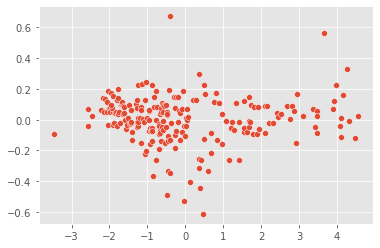

In [21]:
X2D=PCA(n_components=2).fit_transform(df_PCA_scalled)
sns.scatterplot(x=X2D[:,0],y=X2D[:,1])
df_PCA_final=pd.DataFrame(data=X2D,columns=["num1", "num2"])
df_PCA_final.head()

### assign new feature to dataset 

In [22]:
df_new = df.drop(['Overall Life', 'Male Life', 'Female Life'], axis = 1)

In [23]:
df_new = pd.concat([df_new, df_PCA_final], axis=1)

## Deteksi Outlier dengan Gaussian Mixture

C:\Users\arryp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arryp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

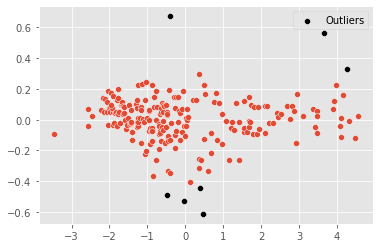

In [24]:
from sklearn.mixture import GaussianMixture
gauss=GaussianMixture().fit(X2D)
scores = gauss.score_samples(X2D)
thresh = np.quantile(scores, 0.03)
index = np.where(scores <= thresh)
outliers = X2D[index]

sns.scatterplot(x=X2D[:,0],y=X2D[:,1])
sns.scatterplot(x=outliers[:,0],y=outliers[:,1])
sns.scatterplot(outliers[:,0],outliers[:,1], color='k', label ='Outliers')

Terdapat outliers yang ditandai dengan warna hitam pada grafik diatas 

***

# Pendefinisian Model

In [25]:
model = KMeans(n_clusters=2, random_state=42)

## Scalling

In [26]:
df_new_scalled = scaler.fit_transform(df_new)

## Fit Model

In [27]:
model.fit(df_new_scalled)

KMeans(n_clusters=2, random_state=42)

## Elbow Method

Text(0, 0.5, 'Inertia')

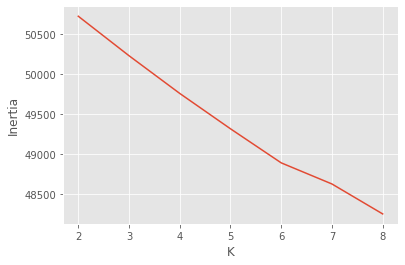

In [28]:
K=[2,3,4,5,6,7,8]
inertia=[KMeans(n_clusters=i).fit(df_new_scalled).inertia_ for i in K]
plt.plot(K,inertia)
plt.xlabel('K')
plt.ylabel('Inertia')

## Silhouette Score

Text(0, 0.5, 'Silhouette Score')

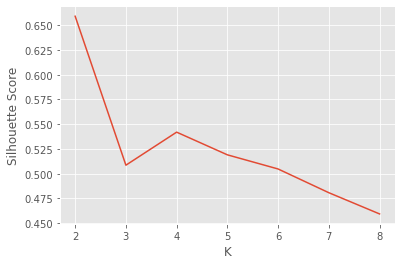

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score
silhoutte =[silhouette_score(X2D, KMeans(n_clusters=i).fit(X2D).labels_) for i in K]
plt.plot(K,silhoutte)
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## Visualisasi Silhouette Score 

In [30]:
def plot_silhouette(range_n_clusters,X):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.6590827665905286
For n_clusters = 3 The average silhouette_score is : 0.5086442840223461
For n_clusters = 4 The average silhouette_score is : 0.5420096807105615
For n_clusters = 5 The average silhouette_score is : 0.5191109983162965
For n_clusters = 6 The average silhouette_score is : 0.504813654611479
For n_clusters = 7 The average silhouette_score is : 0.4803621468913846
For n_clusters = 8 The average silhouette_score is : 0.46150467818555724


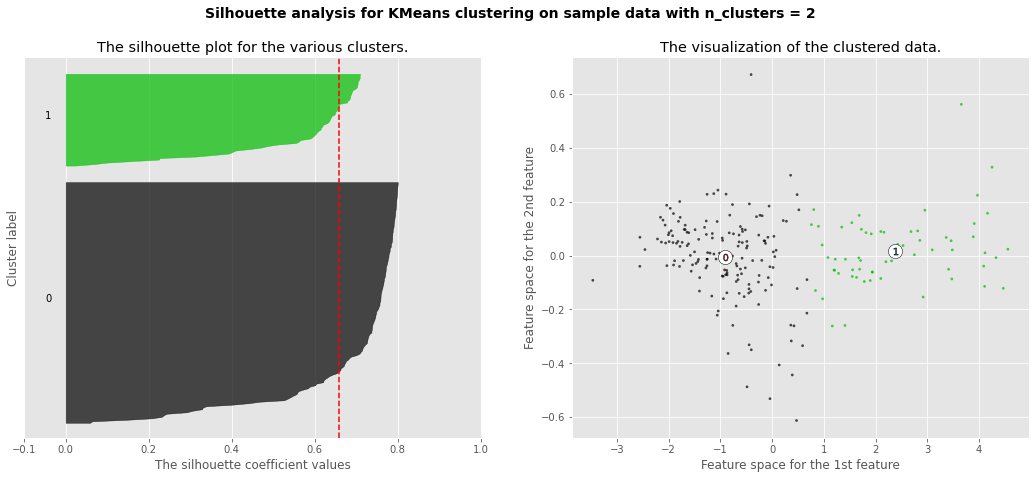

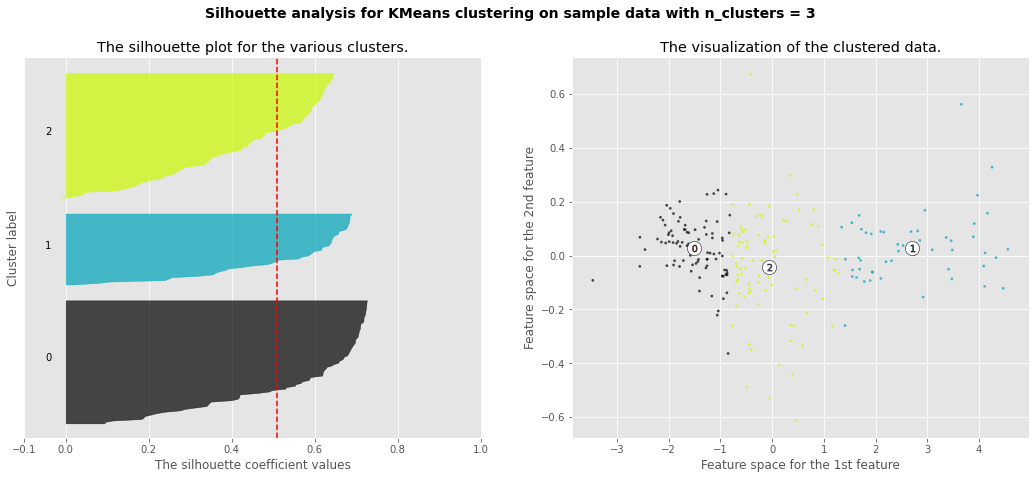

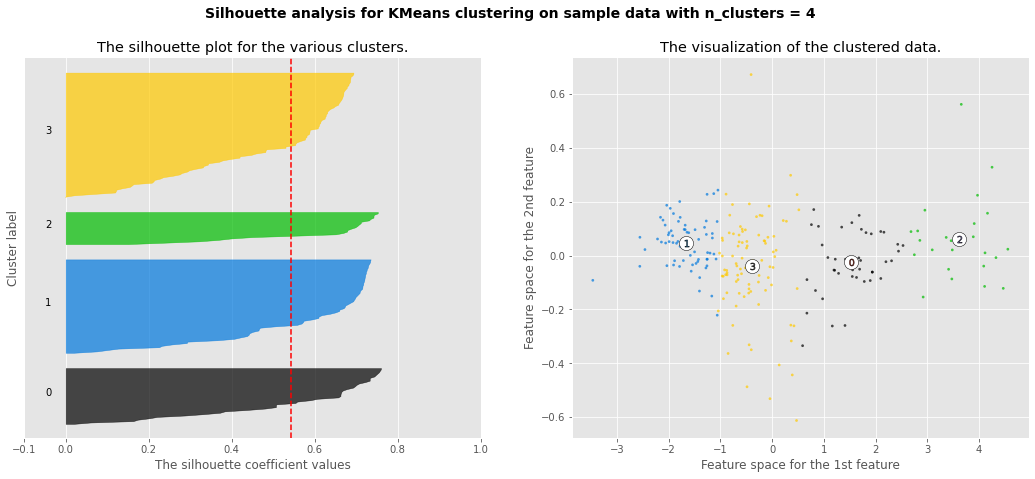

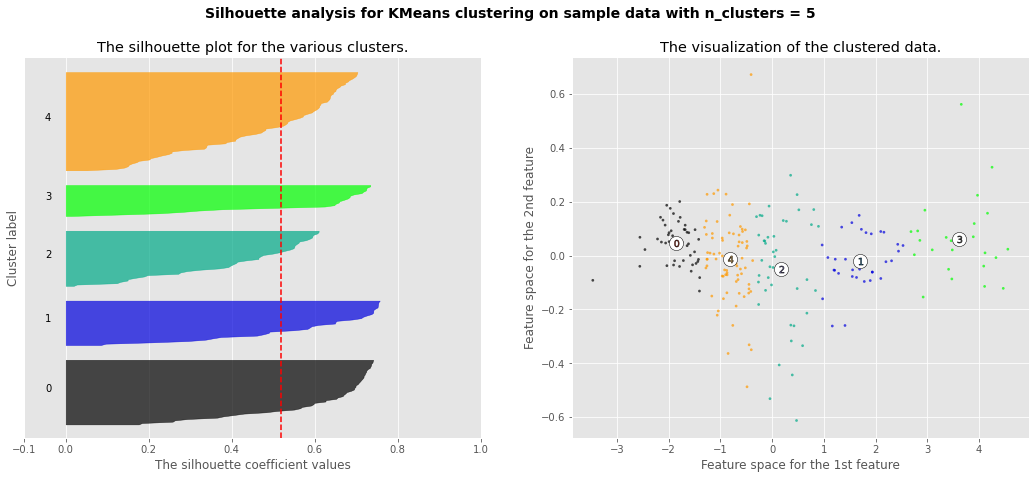

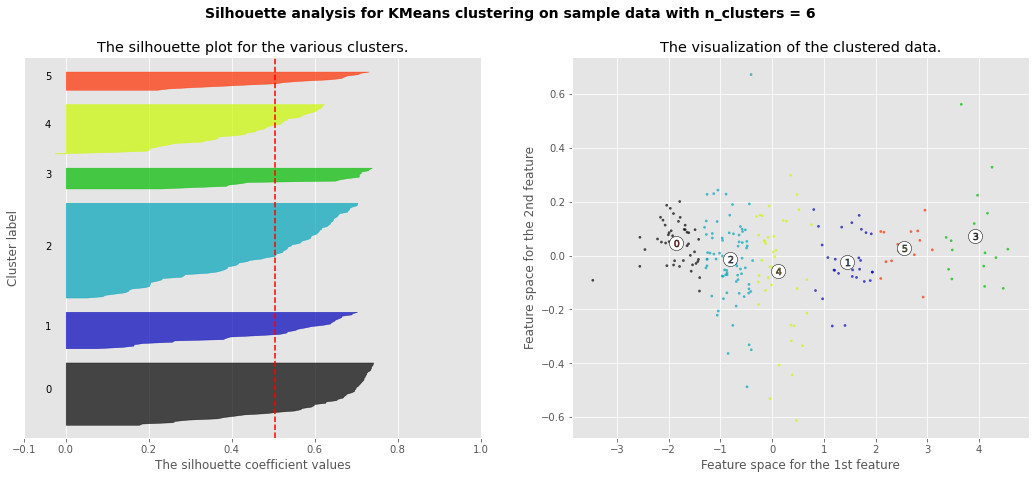

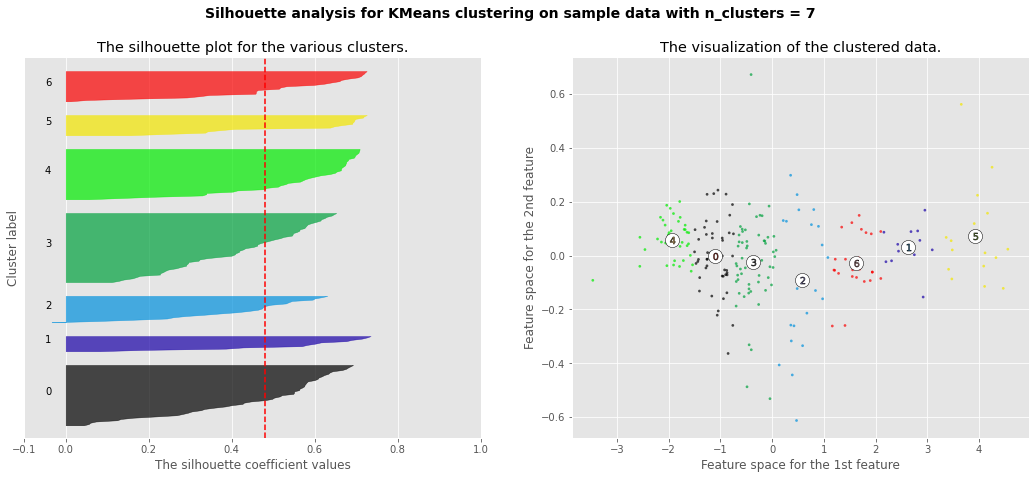

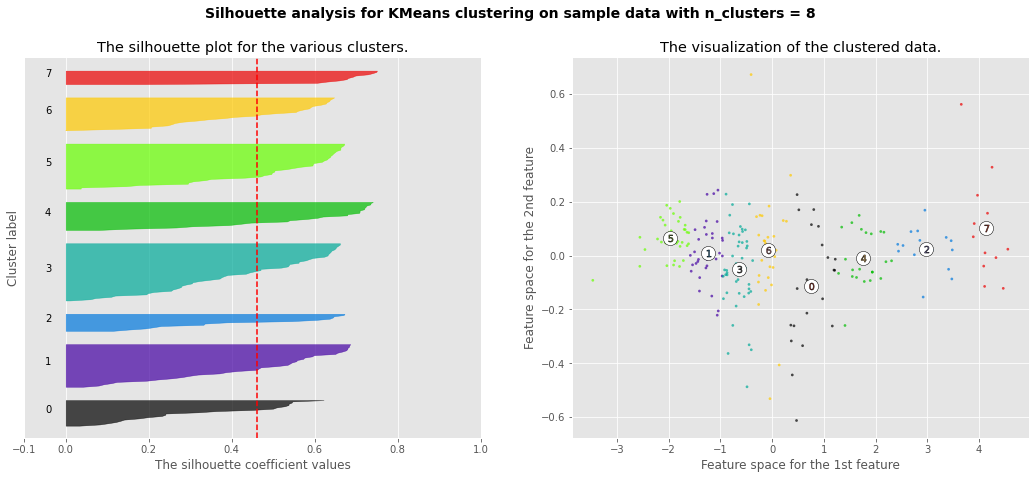

In [31]:
import matplotlib.cm as cm
plot_silhouette(K,X2D)

Berdasarkan visualisasi Silhouette Score diatas maka :
> K yang diambil adalah  n_cluster 2 yang berhasil mendapatkan skor 65,90 %, dapat terlihat jelas pada sebaran data juga telah terlihat dengan baik pemisahan antara cluster 0 dan cluster 1

# Model Inference

In [32]:
df['Cluster'] = model.labels_

In [33]:
df['Cluster'].value_counts()

1    116
0    107
Name: Cluster, dtype: int64

<AxesSubplot:>

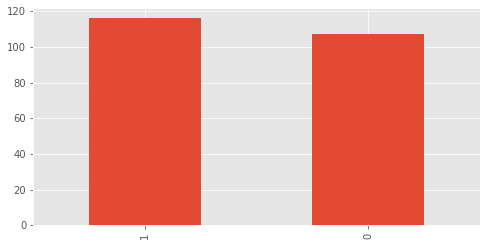

In [34]:
df['Cluster'].value_counts().plot(kind='bar', figsize=(8,4))

# Data Cluster Analysist

In [45]:
#panggil ulang DF sebagai data asli untuk digambarkan didalam label cluster
df = pd.read_csv('Data/Life_expectancy_dataset.csv')
df['Cluster'] = model.labels_

## Cluster 0

In [46]:
df0_withlabels = df[df['Cluster'] == 0]
df0_withlabels

,Rank,Country,Overall Life,Male Life,Female Life,Continent,Cluster
105,106,Saudi Arabia,75.3,73.2,77.4,Asia,0
108,109,Malaysia,75.0,72.2,78.0,Asia,0
109,110,West Bank,75.0,73.0,77.1,Asia,0
110,111,Iraq,74.9,72.6,77.2,Asia,0
112,113,Syria,74.9,72.5,77.4,Asia,0
...,...,...,...,...,...,...,...
218,219,Gabon,52.1,51.6,52.5,Africa,0
219,220,Swaziland,51.6,52.2,51.0,Africa,0
220,221,Afghanistan,51.3,49.9,52.7,Asia,0
221,222,Guinea-Bissau,50.6,48.6,52.7,Africa,0


In [47]:
df0_withlabels.describe()

,Rank,Overall Life,Male Life,Female Life,Cluster
count,107.000000,107.000000,107.000000,107.000000,107.0
mean,168.485981,65.828037,63.752336,67.915888,0.0
std,33.074349,7.319498,6.885319,7.868856,0.0
min,106.000000,50.200000,48.600000,51.000000,0.0
25%,140.500000,60.900000,59.100000,62.750000,0.0
50%,170.000000,66.600000,64.300000,69.500000,0.0
75%,196.500000,72.700000,70.000000,75.100000,0.0
max,223.000000,75.300000,75.800000,78.100000,0.0


### Distribusi Data Cluster 0

C:\Users\arryp\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


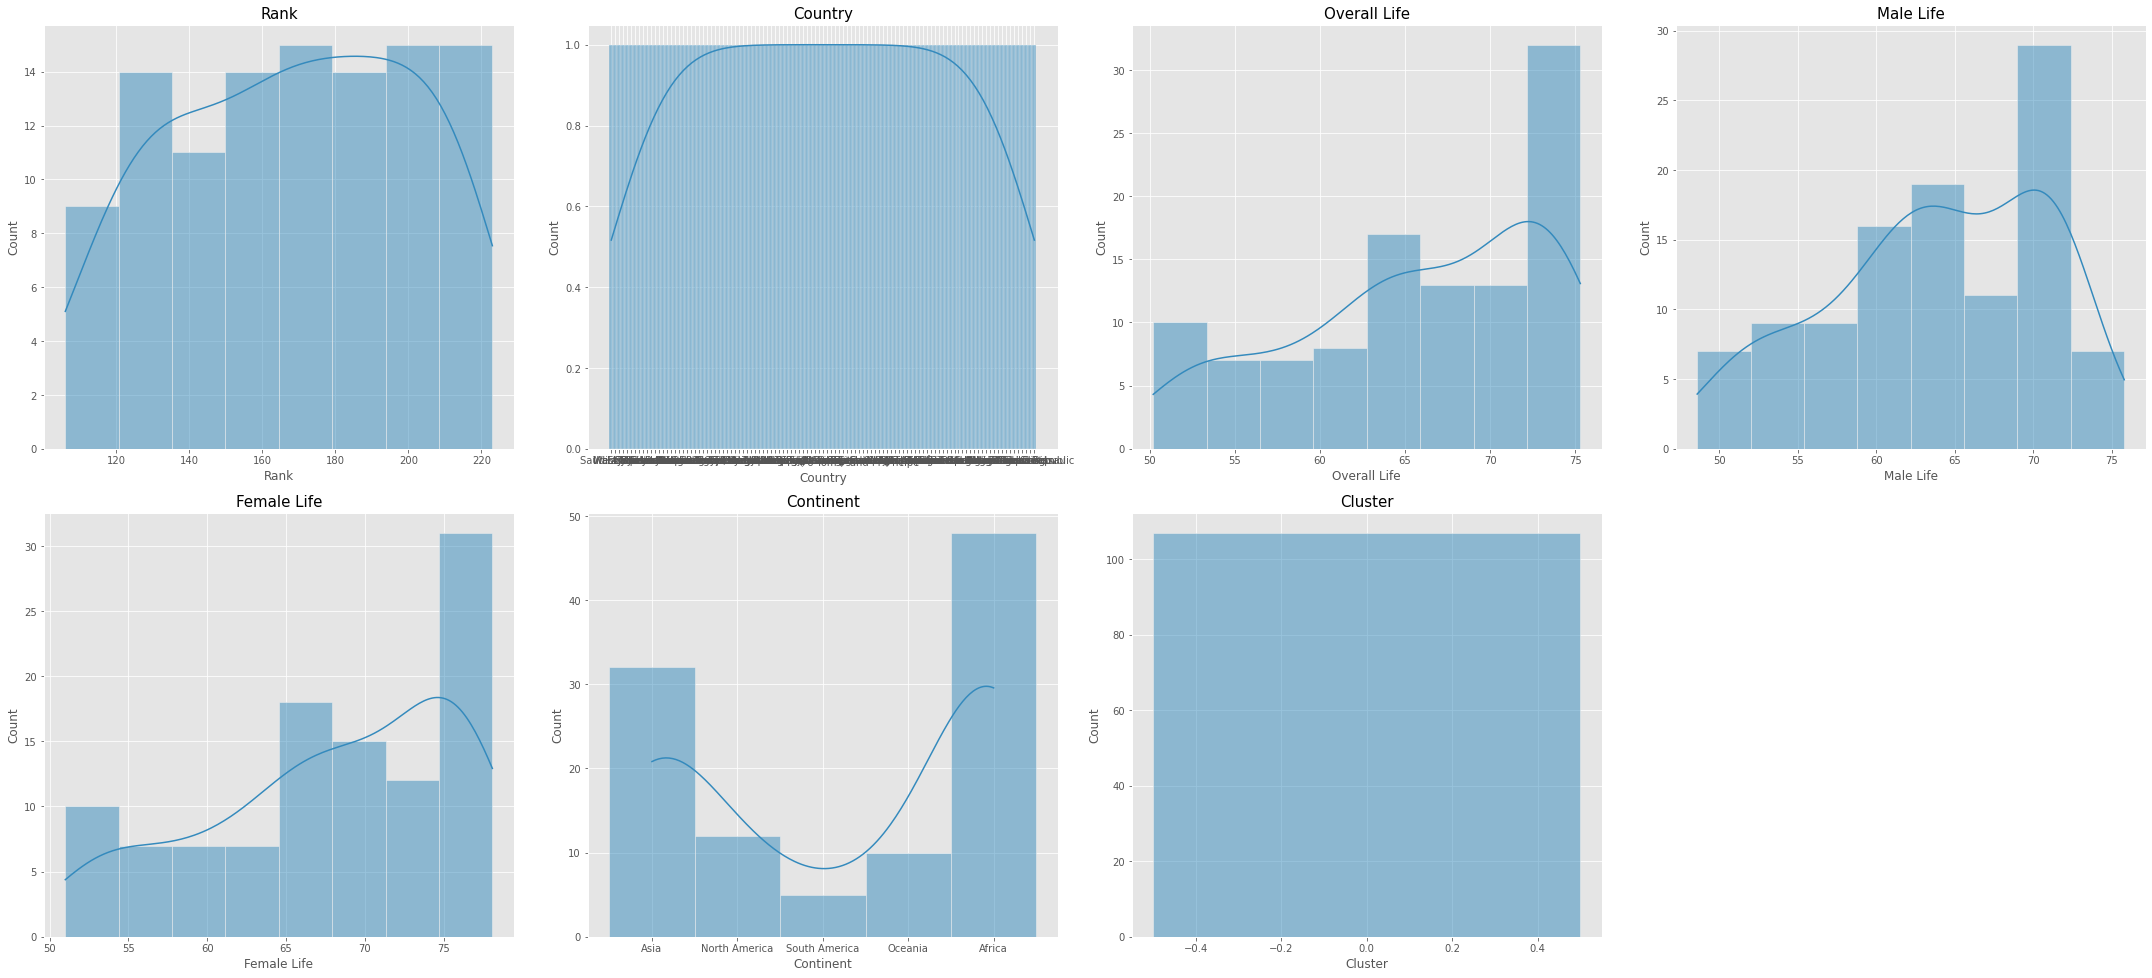

In [48]:
cols = list(df0_withlabels.columns)
plt.figure(figsize = (30, 20))
for i in range(len(cols)):
    plt.subplot(len(cols)//3+1, 4, i + 1)
    sns.histplot(df0_withlabels[cols[i]], kde=True)
    plt.title(cols[i], fontsize = 15)
    
plt.tight_layout()
plt.show()

* Sebaran data Cluster 0 didominasi oleh negara negara dari Benua Afrika dan asia yang memiliki angka harapan hidup baik Male, Female, ataupun Overall yang lebih rendah jika dibandingkan dengan Eropa
* Benua Eropa tidak masuk kedalam cluster 01 diduga dikarenakan sebaran data life expetancy yg jauh lebih tinggi dibandingkan dengan benua lainnya, utamanya jika dibandingkan dengan negara dari Benua Afrika dan Asia
* Negara yang termasuk didalam Cluster 01 merupakan negara yang memiliki ranking terrendah 106 dan tertinggi pada 220, menandakan cluster ini merupakan negara negara yang memiliki angha harapan hidup lebih rendah jika dibandingkan dengan Cluster 01


## Cluster 01

In [49]:
df1_withlabels = df[df['Cluster'] == 1]
df1_withlabels

,Rank,Country,Overall Life,Male Life,Female Life,Continent,Cluster
0,1,Monaco,89.5,85.6,93.5,Europe,1
1,2,Japan,85.0,81.7,88.5,Asia,1
2,3,Singapore,85.0,82.3,87.8,Asia,1
3,4,Macau; China,84.5,81.6,87.6,Asia,1
4,5,San Marino,83.3,80.7,86.1,Europe,1
...,...,...,...,...,...,...,...
120,121,Latvia,74.5,69.9,79.3,Europe,1
137,138,Belarus,72.7,67.2,78.6,Europe,1
141,142,Azerbaijan,72.5,69.5,75.8,Europe,1
147,148,Ukraine,71.8,67.1,76.9,Europe,1


In [50]:
df1_withlabels.describe()

,Rank,Overall Life,Male Life,Female Life,Cluster
count,116.000000,116.000000,116.000000,116.000000,116.0
mean,59.896552,78.631034,75.843103,81.571552,1.0
std,36.336921,3.070148,3.379741,2.928208,0.0
min,1.000000,70.700000,66.900000,74.800000,1.0
25%,29.750000,76.200000,73.500000,79.275000,1.0
50%,58.500000,78.450000,75.800000,81.300000,1.0
75%,87.250000,81.050000,78.500000,83.525000,1.0
max,153.000000,89.500000,85.600000,93.500000,1.0


C:\Users\arryp\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


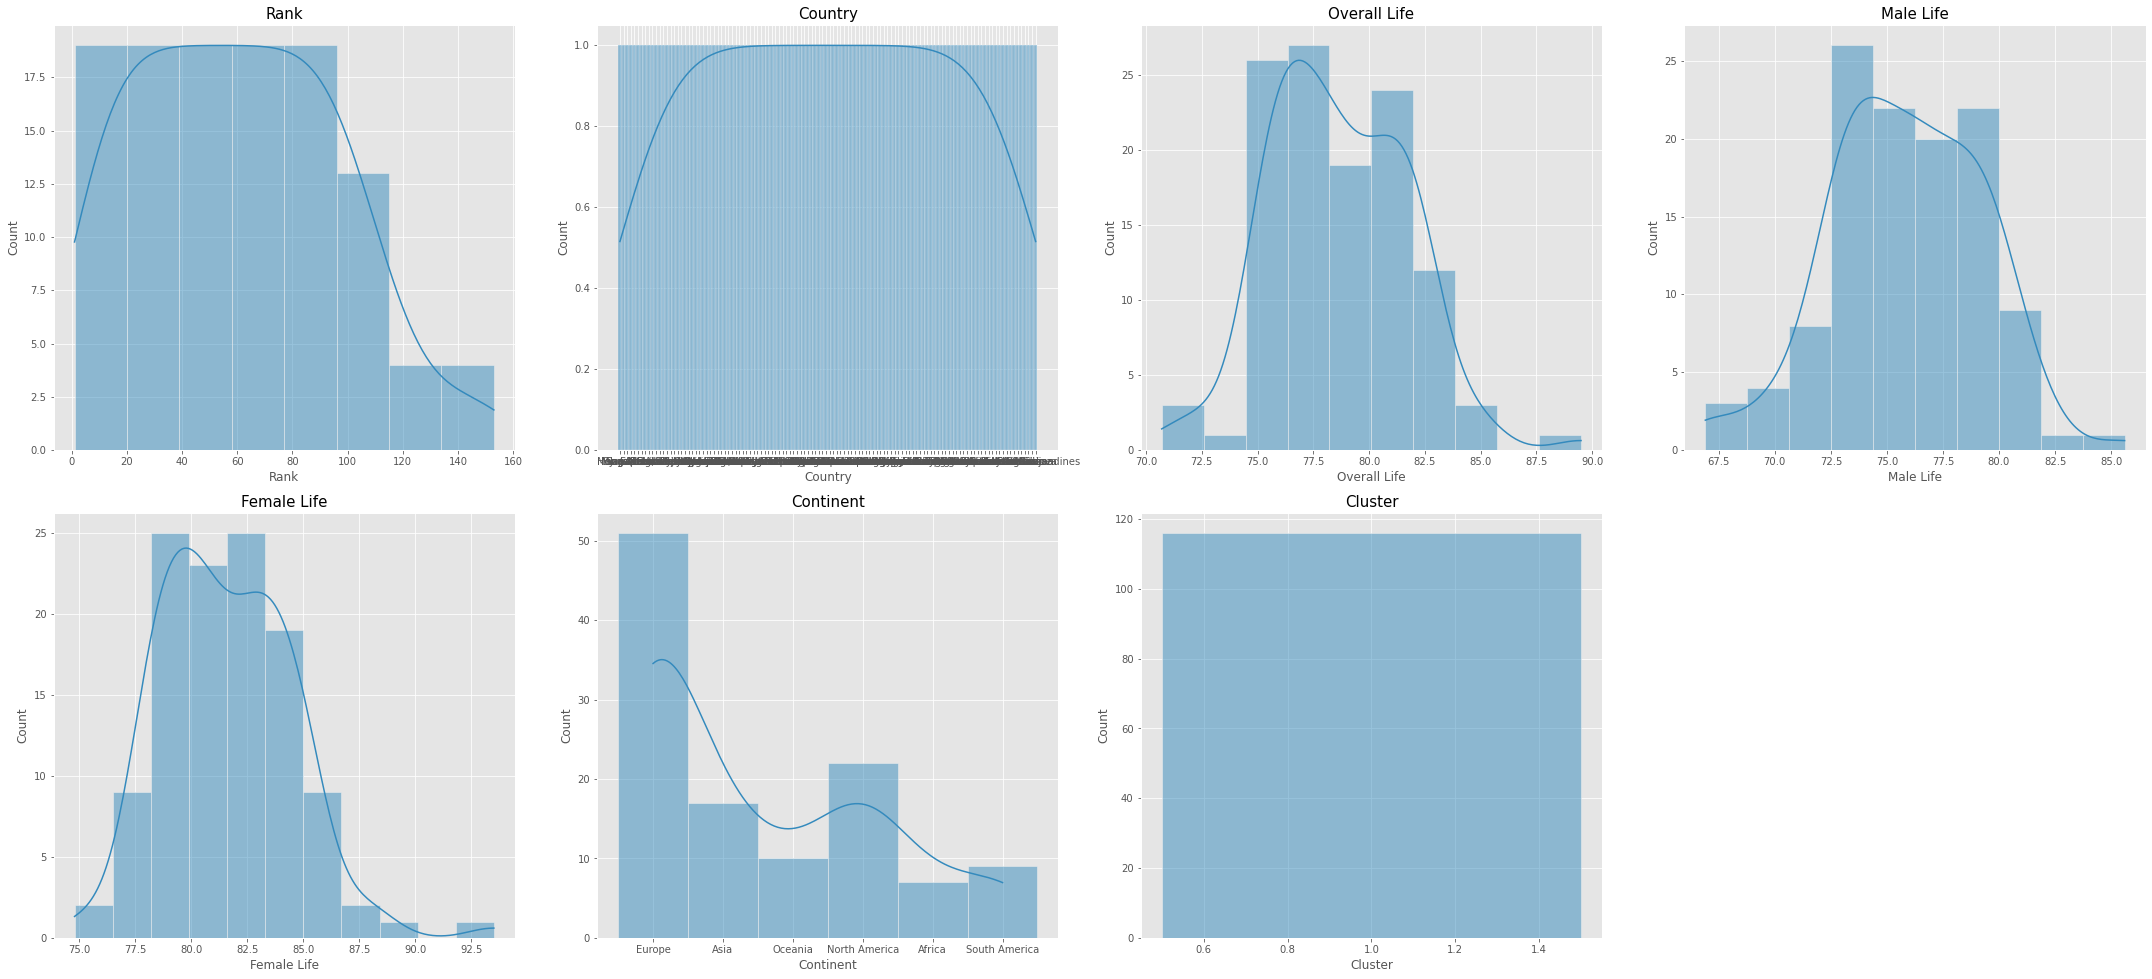

In [51]:
cols = list(df1_withlabels.columns)
plt.figure(figsize = (30, 20))
for i in range(len(cols)):
    plt.subplot(len(cols)//3+1, 4, i + 1)
    sns.histplot(df1_withlabels[cols[i]], kde=True)
    plt.title(cols[i], fontsize = 15)
    
plt.tight_layout()
plt.show()

* Berdasarkan benua, Negara negara yang masuk didalam cluster 01 adalah negara Eropa yang memiliki angka harapan hidup lebih tinggi, komposisi pada cluster ini didominasi oleh negara Erorpa dan North America
* Distribusi data pada Female Life, Male Life dan Overall lebih terdistribusi normal dikarenakan jumlah outlier pada data eropa dan asia telah masuk ke dalam kategori 0 yang memiliki komposisi negara asia dan afrika lebih banyak dari cluster 01
* Negara yang masuk dalam Cluster 01 merupakan negara yang memiliki ranking lebih tinggi dengan  dengan rangking minimum 1 dan maksimum 153